In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.integrate import cumulative_trapezoid
from ad99 import AlexanderDunkerton1999
from constants import GRAV,R_DRY,C_P

## Load Loon Data

In [2]:
from glob import iglob 
import os
LOON_GW_DATA_PATH = 'data/loon'
u_flux_ptv = []
u_flux_ntv = []
v_flux_ntv = []
v_flux_ptv = []
for f in iglob(os.path.join(LOON_GW_DATA_PATH,'*flux.npy')):
    flux = np.load(f)
    u_flux_ntv.append(flux[0])
    u_flux_ptv.append(flux[1])
    v_flux_ntv.append(flux[2])    
    v_flux_ptv.append(flux[3])


loon_ntv_u = np.concatenate(u_flux_ntv)
loon_ptv_u = np.concatenate(u_flux_ptv)
loon_ntv_v = np.concatenate(v_flux_ntv)
loon_ptv_v = np.concatenate(v_flux_ptv)
loon_abs_v = np.concatenate([np.abs(loon_ntv_v)+np.abs(loon_ptv_v)])
loon_abs_u = np.concatenate([np.abs(loon_ntv_u)+np.abs(loon_ptv_u)])
loon_net_u = np.concatenate([loon_ntv_u+loon_ptv_u])
loon_net_v = np.concatenate([loon_ntv_v+loon_ptv_v])

LOON_DATA = {
    'u_flux_ntv': loon_ntv_u,
    'u_flux_ptv': loon_ptv_u,
    'v_flux_ntv': loon_ntv_v,
    'v_flux_ptv': loon_ptv_v,
    'u_flux_abs': loon_abs_u,
    'v_flux_abs': loon_abs_v,
    'u_flux_net': loon_net_u,
    'v_flux_net': loon_net_v
}

## Load MiMA sim data + Loon masks

In [3]:
## Load in MiMA data
ds = xr.open_dataset('data/atmos_daily_flag0.nc')
ds['p'] = (("time","pfull","lat","lon"),ds.ps.data[:,None,:,:]*(ds.bk.values[1:] + ds.bk.values[:-1])[None,:,None,None]/2)

In [4]:
ds_mask_trop = xr.open_dataset('data/loon_masks.nc')

ds_mask_trop['lon'] = (ds_mask_trop.lon + 360) % 360 
ds_mask_trop = ds_mask_trop.sortby('lon')

interp_mask = ds_mask_trop.interp(lat=ds.lat,lon=ds.lon,method='nearest').astype(bool)
interp_mask ## Masks

<xarray.Dataset> Size: 50kB
Dimensions:                 (lat: 64, lon: 128)
Coordinates:
  * lat                     (lat) float32 256B -87.86 -85.1 ... 85.1 87.86
  * lon                     (lon) float32 512B 0.0 2.812 5.625 ... 354.4 357.2
Data variables:
    tropical_atlantic       (lat, lon) bool 8kB False False ... False False
    extratropical_atlantic  (lat, lon) bool 8kB False False ... False False
    extratropical_pacific   (lat, lon) bool 8kB False False ... False False
    indian                  (lat, lon) bool 8kB False False ... False False
    tropical_pacific        (lat, lon) bool 8kB False False ... False False
    southern_ocean          (lat, lon) bool 8kB False False ... False False

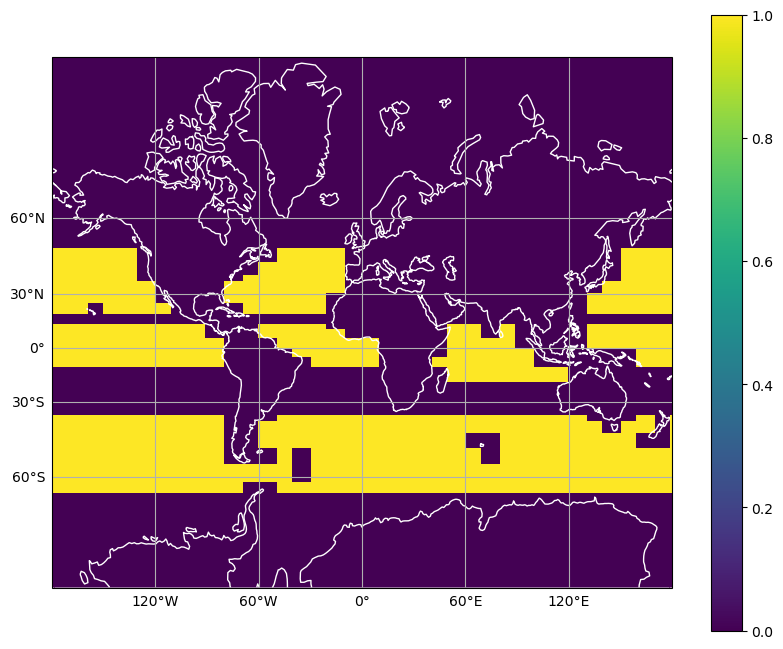

In [5]:
total_mask = sum(interp_mask[d] for d in interp_mask.data_vars)
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.Mercator())
total_mask.plot.pcolormesh(transform=ccrs.PlateCarree(),ax=ax)
ax.coastlines(color='white')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

In [6]:
ocean_expac = ds.where(total_mask).stack(points = ['lat','lon'])
ocean_expac = ocean_expac.dropna('points',how='all')
ocean_expac = ocean_expac[['ucomp','temp','vcomp','height','gwfu_cgwd','gwfv_cgwd','omega','p']]
ocean_expac = ocean_expac.transpose('time','points','pfull')

In [7]:
ocean_expac

<xarray.Dataset> Size: 1GB
Dimensions:    (time: 360, pfull: 40, points: 2504)
Coordinates:
  * time       (time) object 3kB 0021-01-02 00:00:00 ... 0022-01-01 00:00:00
  * pfull      (pfull) float32 160B 0.1782 0.5562 0.7238 ... 821.4 902.2 970.5
  * points     (points) object 20kB MultiIndex
  * lat        (points) float32 10kB -62.79 -62.79 -62.79 ... 48.84 48.84 48.84
  * lon        (points) float32 10kB 0.0 2.812 5.625 8.438 ... 343.1 345.9 348.8
Data variables:
    ucomp      (time, points, pfull) float32 144MB -37.59 -31.38 ... -14.25
    temp       (time, points, pfull) float32 144MB 221.7 276.4 ... 270.4 276.4
    vcomp      (time, points, pfull) float32 144MB 9.313 22.58 ... -2.437 -3.859
    height     (time, points, pfull) float32 144MB 6.109e+04 5.347e+04 ... 285.5
    gwfu_cgwd  (time, points, pfull) float32 144MB 0.0001064 0.0001064 ... 0.0
    gwfv_cgwd  (time, points, pfull) float32 144MB -1.251e-05 -3.243e-06 ... 0.0
    omega      (time, points, pfull) float32 144MB 0.000405 ... 0.04133
    p          (time, points, pfull) float32 144MB 23.74 54.67 ... 9.556e+04
Attributes:
    filename:  atmos_daily_flag0.nc
    title:     MiMA
    history:   Tue Apr  8 00:09:21 2025: ncatted -a calendar,time,o,c,360_day...
    NCO:       netCDF Operators version 5.2.4 (Homepage = http://nco.sf.net, ...

In [8]:
us = ocean_expac.ucomp.values[...,::-1]
zs = ocean_expac.height.values[...,::-1]
temps= ocean_expac.temp.values[...,::-1]
omega = ocean_expac.omega.values[...,::-1] 
gwfu = ocean_expac.gwfu_cgwd.values[...,::-1]
gwfv = ocean_expac.gwfv_cgwd.values[...,::-1]
pfull = ocean_expac.p.values[...,::-1]
lats = ocean_expac.lat.values
lons = ocean_expac.lon.values

Coordinates:
  * time     (time) object 3kB 0021-01-02 00:00:00 ... 0022-01-01 00:00:00
  * pfull    (pfull) float32 160B 0.1782 0.5562 0.7238 ... 821.4 902.2 970.5
  * points   (points) object 20kB MultiIndex
  * lat      (points) float32 10kB -62.79 -62.79 -62.79 ... 48.84 48.84 48.84
  * lon      (points) float32 10kB 0.0 2.812 5.625 8.438 ... 343.1 345.9 348.8

## determine values needed for ad99


In [9]:

dTdz = np.gradient(temps,axis=-1)/np.gradient(zs,axis=-1)
Ns2 = GRAV/temps*(dTdz + GRAV/C_P) 
bflim = 5e-3
Ns2 = xr.where(Ns2 < bflim**2,bflim**2,Ns2)
Ns = np.sqrt(Ns2)
rho = (pfull)/(R_DRY*temps)

In [10]:
phalf = np.broadcast_to(ds.phalf[::-1].data,(*us.shape[:-1],len(ds.phalf)))*100

## Obtain true drag/momentum flux PRESCRIBED profiles from MiMA
### Validate all different momentum flux methodologies

In [11]:
from mimaad99 import mima_gwd_ptv_flux,mima_gwd_ntv_flux,mima_gwd_abs_flux,mima_gwd_abs_flux_half,mima_gwd_net_flux

### Top bottom integrals using the zero flux condition at the top boundary. 
uw_mima_ptv_top = mima_gwd_ptv_flux(gwfu,pfull,from_top=False)
uw_mima_ntv_top = mima_gwd_ntv_flux(gwfu,pfull,from_top=False)
# uw_mima_abs_top = mima_gwd_abs_flux(gwfu,pfull,from_top=False)
# uw_mima_net_top = mima_gwd_net_flux(gwfu,pfull,from_top=False)
# uw_mima_abs_half = mima_gwd_abs_flux_half(gwfu,phalf,from_top=False) # Use half levels for the integral. 

In [12]:
ad99_mima = AlexanderDunkerton1999(source_level_height=9000,Fs0=4.3e-3,damp_level_height=50000)
ad99_alt = AlexanderDunkerton1999(dc=0.4,source_level_height=9000,Fs0=4.3e-3,damp_level_height=None,exclude_unbroken=True,use_intrinsic_c=10.0)

In [13]:
from joblib import Parallel, delayed

## Integrals from bottom up. 
uw_mima_ptv_bottom = np.zeros_like(gwfu)
uw_mima_ntv_bottom = np.zeros_like(gwfu)




def get_mima_ad99(time,point,ad99:AlexanderDunkerton1999):
    source =  ad99.filtered_source_spectrum(us[time,point],Ns[time,point],zs[time,point],rho[time,point],lat=lats[point])
    uw_mima_ptv_up = ad99.gwd_ptv_momentum_flux_upwards(gwfu[time,point],us[time,point],Ns[time,point],zs[time,point],rho[time,point],lat=lats[point],source_spectrum=source)
    uw_mima_ntv_up = ad99.gwd_ntv_momentum_flux_upwards(gwfu[time,point],us[time,point],Ns[time,point],zs[time,point],rho[time,point],lat=lats[point],source_spectrum=source)

    return time,point,uw_mima_ptv_up,uw_mima_ntv_up

results = Parallel(n_jobs=-1)(delayed(get_mima_ad99)(time,point,ad99_mima) for time in range(us.shape[0]) for point in range(us.shape[1]))

for time,point, uw_mima_ptv_up_val, uw_mima_ntv_up_val in results:
    uw_mima_ptv_bottom[time,point] = uw_mima_ptv_up_val
    uw_mima_ntv_bottom[time,point] = uw_mima_ntv_up_val

uw_mima_abs_bottom = np.abs(uw_mima_ptv_bottom) + np.abs(uw_mima_ntv_bottom)
uw_mima_net_bottom = uw_mima_ptv_bottom + uw_mima_ntv_bottom    
uw_mima_abs_top = np.abs(uw_mima_ptv_top) + np.abs(uw_mima_ntv_top)
uw_mima_net_top = uw_mima_ptv_top + uw_mima_ntv_top


## Run AD99 on MiMA u profiles 
Get all ways of calculating momentum flux

In [14]:
from joblib import Parallel, delayed
from tqdm.notebook import tqdm 
gwd = np.zeros_like(us)
uw_ptv_bottom = np.zeros_like(us)
uw_ptv_top = np.zeros_like(us)
uw_ptv_alt = np.zeros_like(us)
uw_ntv_top = np.zeros_like(us)
uw_ntv_bottom = np.zeros_like(us)
uw_ntv_alt = np.zeros_like(us)

def get_ad99(i:int,j:int,ad99:AlexanderDunkerton1999):
    gwd = ad99.gwd(us[i,j],Ns[i,j],zs[i,j],rho[i,j],lat=lats[j])
    source = ad99.filtered_source_spectrum(us[i,j],Ns[i,j],zs[i,j],rho[i,j],lat=lats[j])
    uw_ptv_bottom= ad99.gwd_ptv_momentum_flux_upwards(gwd,us[i,j],Ns[i,j],zs[i,j],rho[i,j],lat=lats[j],source_spectrum=source)
    uw_ntv_bottom = ad99.gwd_ntv_momentum_flux_upwards(gwd,us[i,j],Ns[i,j],zs[i,j],rho[i,j],lat=lats[j],source_spectrum=source)
    uw_ptv_top = ad99.gwd_ptv_momentum_flux_downwards(gwd,zs[i,j],rho[i,j])
    uw_ntv_top = ad99.gwd_ntv_momentum_flux_downwards(gwd,zs[i,j],rho[i,j])
    uw_ntv_alt,uw_ptv_alt = ad99.momentum_flux_neg_ptv(us[i,j],Ns[i,j],zs[i,j],rho[i,j],lat=lats[j])

    return i,j,gwd,uw_ptv_bottom,uw_ntv_bottom,uw_ptv_top,uw_ntv_top, uw_ptv_alt,uw_ntv_alt, 

results = Parallel(n_jobs=-1)(delayed(get_ad99)(i,j,ad99_alt) for i in range(us.shape[0]) for j in range(us.shape[1]))

for i,j,gwd_val,uw_ptv_bottom_val,uw_ntv_bottom_val, uw_ptv_top_val, uw_ntv_top_val, uw_ptv_alt_val, uw_ntv_alt_val in results:
    gwd[i,j] = gwd_val
    
    uw_ptv_bottom[i,j] = uw_ptv_bottom_val
    uw_ntv_bottom[i,j] = uw_ntv_bottom_val

    uw_ptv_top[i,j] = uw_ptv_top_val
    uw_ntv_top[i,j] = uw_ntv_top_val

    uw_ptv_alt[i,j] = uw_ptv_alt_val
    uw_ntv_alt[i,j] = uw_ntv_alt_val


uw_net_bottom = uw_ptv_bottom + uw_ntv_bottom
uw_net_top = uw_ptv_top + uw_ntv_top
uw_net_alt = uw_ptv_alt + uw_ntv_alt
uw_abs_bottom = np.abs(uw_ptv_bottom) + np.abs(uw_ntv_bottom)
uw_abs_top = np.abs(uw_ptv_top) + np.abs(uw_ntv_top)
uw_abs_alt = np.abs(uw_ptv_alt) + np.abs(uw_ntv_alt)

In [27]:
uw_ptv = xr.DataArray(uw_ptv_alt[...,::-1],dims=('time','points','pfull'),coords=ocean_expac.coords)
uw_ntv = xr.DataArray(uw_ntv_alt[...,::-1],dims=('time','points','pfull'),coords=ocean_expac.coords)

In [30]:
ocean_expac['uw_ntv'] = uw_ntv
ocean_expac['uw_ptv'] = uw_ptv

In [36]:
ocean_expac.reset_index('points').to_netcdf('data/mima_ref_ad99_atmosdaily0.nc')

## Diagnostic Plot

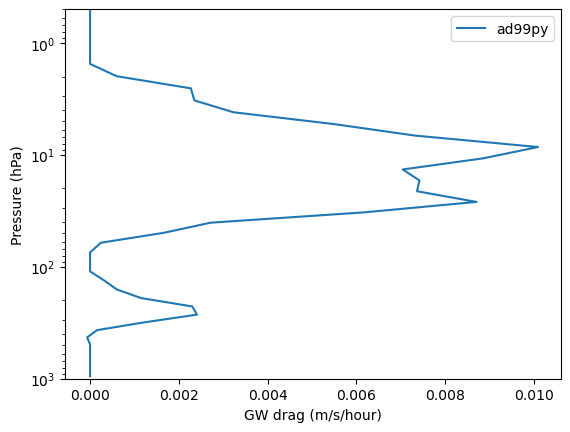

In [15]:
import matplotlib.pyplot as plt 
point = 2405
time = 0
# plt.plot(gwfu[time,point]*3600,pfull[time,point]/100,label="mimaad99")
plt.plot(gwd[time,point]*3600,pfull[time,point]/100,label="ad99py")
plt.yscale('log')
plt.ylabel('Pressure (hPa)')
plt.ylim(0.5,1000)
plt.xlabel('GW drag (m/s/hour)')
plt.gca().invert_yaxis()
plt.legend()

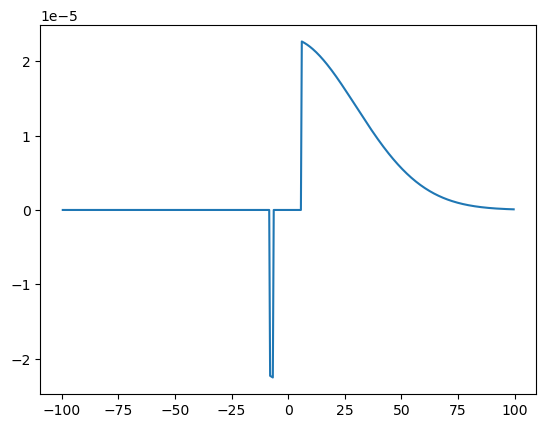

In [16]:
source = ad99_alt.filtered_source_spectrum(us[time,point],Ns[time,point],zs[time,point],rho[time,point],lat=lats[point])
plt.plot(ad99_alt.c0,source)

## breaking plot

Text(0.5, 0, 'u (m/s)')

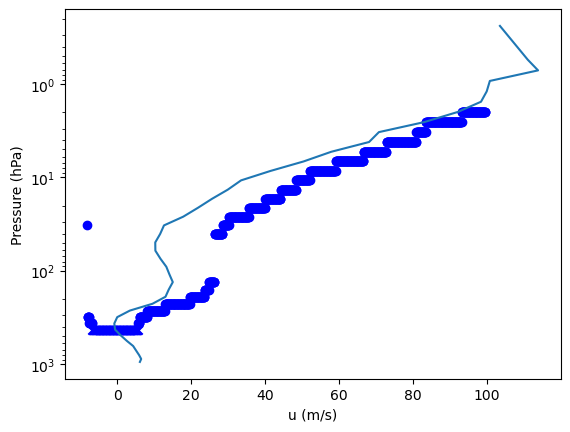

In [26]:
source = ad99_alt.get_source_level(zs[time,point],lat=lats[point])
reflecting,breaking,  = ad99_alt.get_breaking_levels(us[time,point],Ns[time,point],zs[time,point],rho[time,point],lat=lats[point])
for i,(r,b) in enumerate(zip(reflecting,breaking)):
 
    if r >= 0 :
        if r == source:
            plt.scatter(ad99_alt.c0[i],pfull[time,point,r]/100,marker='x',color='red')
        else:
            plt.scatter(ad99_alt.c0[i],pfull[time,point,r]/100,marker='o',color='red')
    if b >= 0:
        if b == source:
            plt.scatter(ad99_alt.c0[i],pfull[time,point,b]/100,marker='x',color='blue')
        else:
            plt.scatter(ad99_alt.c0[i],pfull[time,point,b]/100,marker='o',color='blue')
plt.plot(us[time,point],pfull[time,point]/100,label="u")
plt.gca().invert_yaxis()    
plt.yscale('log')
plt.ylabel('Pressure (hPa)')
plt.xlabel('u (m/s)')

## Absolute momentum flux diagnostic

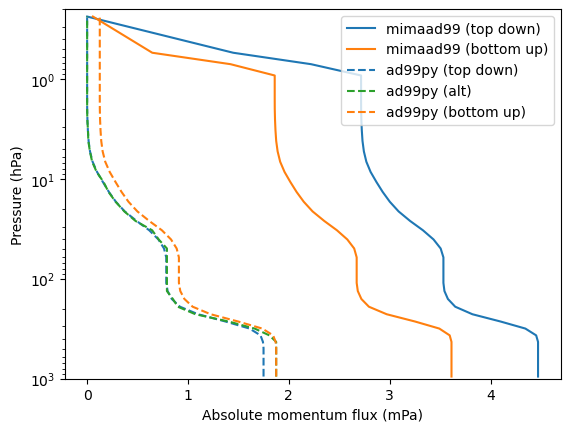

In [27]:
plt.plot(uw_mima_abs_top[time,point]*1000,pfull[time,point]/100,label="mimaad99 (top down)")
plt.plot(uw_mima_abs_bottom[time,point]*1000,pfull[time,point]/100,label="mimaad99 (bottom up)",color='C1')
plt.plot(uw_abs_top[time,point]*1000,pfull[time,point]/100,label="ad99py (top down)",color='C0',linestyle='--')
plt.plot(uw_abs_alt[time,point]*1000,pfull[time,point]/100,label="ad99py (alt)",color='C2',linestyle='--')
plt.plot(uw_abs_bottom[time,point]*1000,pfull[time,point]/100,label="ad99py (bottom up)",color='C1',linestyle='--')
plt.yscale('log')
plt.ylabel('Pressure (hPa)')
plt.ylim(0.2,1000)
plt.xlabel('Absolute momentum flux (mPa)')
plt.gca().invert_yaxis()
plt.legend()

## Net momentum flux diagnostic

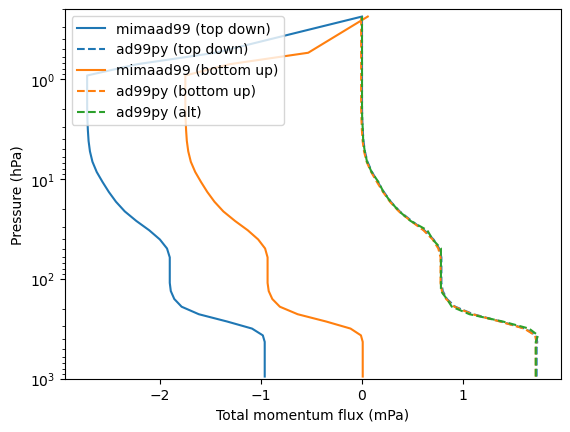

In [28]:
plt.plot(uw_mima_net_top[time,point]*1000,pfull[time,point]/100,label="mimaad99 (top down)",color='C0')
plt.plot(uw_net_top[time,point]*1000,pfull[time,point]/100,label="ad99py (top down)",color='C0',linestyle='--')


plt.plot(uw_mima_net_bottom[time,point]*1000,pfull[time,point]/100,label="mimaad99 (bottom up)",color='C1')
plt.plot(uw_net_bottom[time,point]*1000,pfull[time,point]/100,label="ad99py (bottom up)",color='C1',linestyle='--')

plt.plot(uw_net_alt[time,point]*1000,pfull[time,point]/100,label="ad99py (alt)",color='C2',linestyle='--')

plt.yscale('log')
plt.ylabel('Pressure (hPa)')
plt.ylim(0.2,1000)
plt.xlabel('Total momentum flux (mPa)')
plt.gca().invert_yaxis()
plt.legend()

In [29]:
uw_ptv_bottom[time,point]

array([1.7952299e-03, 1.7952299e-03, 1.7952299e-03, 1.7952299e-03,
       1.7952299e-03, 1.7952299e-03, 1.7952299e-03, 1.7952299e-03,
       1.7769275e-03, 1.6687899e-03, 1.4304656e-03, 1.1576345e-03,
       9.7896613e-04, 8.9744467e-04, 8.5647654e-04, 8.4274786e-04,
       8.4274786e-04, 8.4274786e-04, 8.4274786e-04, 8.2054606e-04,
       7.6495606e-04, 6.7408063e-04, 5.4833392e-04, 4.3116004e-04,
       3.4310523e-04, 2.7446431e-04, 2.1479040e-04, 1.5682093e-04,
       1.1259405e-04, 8.6857530e-05, 7.2911906e-05, 6.5890898e-05,
       6.1345461e-05, 5.8919362e-05, 5.8504691e-05, 5.8504691e-05,
       5.8504691e-05, 5.8504691e-05, 5.8504691e-05, 5.8504691e-05],
      dtype=float32)

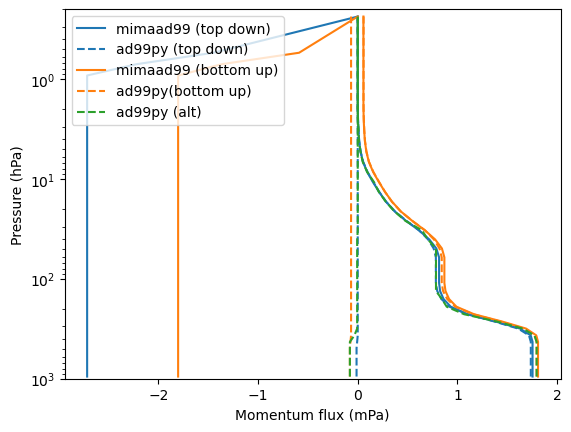

In [30]:
#plt.plot(uw_mima_ntv_bottom[time,point]*1000,pfull[time,point]/100,label="mimaad99 (bottom up)")
plt.plot(uw_mima_ptv_top[time,point]*1000,pfull[time,point]/100,label="mimaad99 (top down)",color='C0')
plt.plot(uw_mima_ntv_top[time,point]*1000,pfull[time,point]/100,label="",color='C0')
plt.plot(uw_ptv_top[time,point]*1000,pfull[time,point]/100,label="ad99py (top down)",color='C0',linestyle='--')
plt.plot(uw_ntv_top[time,point]*1000,pfull[time,point]/100,label="",color='C0',linestyle='--')

plt.plot(uw_mima_ptv_bottom[time,point]*1000,pfull[time,point]/100,label="mimaad99 (bottom up)",color='C1')
plt.plot(uw_mima_ntv_bottom[time,point]*1000,pfull[time,point]/100,label="",color='C1')
plt.plot(uw_ntv_bottom[time,point]*1000,pfull[time,point]/100,label="",color='C1',linestyle='--')
plt.plot(uw_ptv_bottom[time,point]*1000,pfull[time,point]/100,label="ad99py(bottom up)",color='C1',linestyle='--')




plt.plot(uw_ptv_alt[time,point]*1000,pfull[time,point]/100,label="ad99py (alt)",color='C2',linestyle='--')
plt.plot(uw_ntv_alt[time,point]*1000,pfull[time,point]/100,label="",color='C2',linestyle='--')



plt.yscale('log')
plt.ylabel('Pressure (hPa)')
plt.ylim(0.2,1000)
plt.xlabel('Momentum flux (mPa)')
plt.gca().invert_yaxis()
plt.legend()

## PDFs!

In [51]:
level = 100#hPa

## Positive momentum flux

In [52]:
def flatten_flux(flux,pressure):
    i_level = np.argmin(np.abs(pfull/100-pressure),axis=-1,keepdims=True)
    flux = np.abs(np.take_along_axis(flux,i_level,axis=-1).ravel())
    # flux = flux[flux > 0]*1000
    return flux*1000


uw_ptv_mima_bottom_lvl= flatten_flux(uw_mima_ptv_bottom,level)
uw_ptv_mima_top_lvl = flatten_flux(uw_mima_ptv_top,level)

uw_ptv_offline_botto = flatten_flux(uw_ptv_bottom,level)
uw_ptv_offline_top = flatten_flux(uw_ptv_top,level)
uw_ptv_offline_alt = flatten_flux(uw_ptv_alt,level)





In [53]:
def plot_log_histogram(*data, bins=None, labels=None, colors=None,loon='u_flux_ptv',title=None):
    if bins is None:
        bins = np.arange(-3,3.01,0.01)
    if loon: 
        loon_data = LOON_DATA[loon]
        loon_data = np.log10(loon_data[loon_data > 0])
        hist_loon, bin_edges_loon = np.histogram(loon_data, bins=bins,density=True)
        bin_centers_loon = 0.5*(bin_edges_loon[1:] + bin_edges_loon[:-1])
        plt.plot(bin_centers_loon,hist_loon,label='Loon',color='red',linestyle='--')
    for i,d in enumerate(data):
        hist, bin_edges = np.histogram(np.log10(d), bins=bins,density=True)
        bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
        plt.plot(bin_centers,hist,label=labels[i] if labels else None,color=colors[i] if colors else None)

    plt.xlabel('Log10 of momentum flux in mPa')
    plt.ylabel('PDF')
    if title: 
        plt.title(title)
    plt.legend()
    return plt.gca() 

def plot_log_y_histogram(*data,bins=None, labels=None, colors=None,loon='u_flux_ptv',title=None):
    if bins is None:
        bins = np.arange(0,10,0.01 )
    if loon: 
        loon_data = LOON_DATA[loon]
        loon_data = loon_data[loon_data > 0]
        hist_loon, bin_edges_loon = np.histogram(loon_data, bins=bins,density=True)
        bin_centers_loon = 0.5*(bin_edges_loon[1:] + bin_edges_loon[:-1])
        plt.plot(bin_centers_loon,hist_loon,label='Loon',color='red')
    for i,d in enumerate(data):
        
        plt.hist(d,bins=bins,density=True,label=labels[i] if labels else None,color=colors[i] if colors else None,alpha=1/len(data))
    plt.yscale('log')  
    plt.xlabel('Momentum flux (mPa)')
    plt.ylabel('PDF')
    if title:
        plt.title(title)
    plt.legend()
    return plt.gca()

/var/folders/58/1mynp4bn1pg61mc1j6p3nnxc0000gp/T/ipykernel_69899/2979823329.py:11: RuntimeWarning: divide by zero encountered in log10
  hist, bin_edges = np.histogram(np.log10(d), bins=bins,density=True)


<Axes: title={'center': '100hPa u + '}, xlabel='Log10 of momentum flux in mPa', ylabel='PDF'>

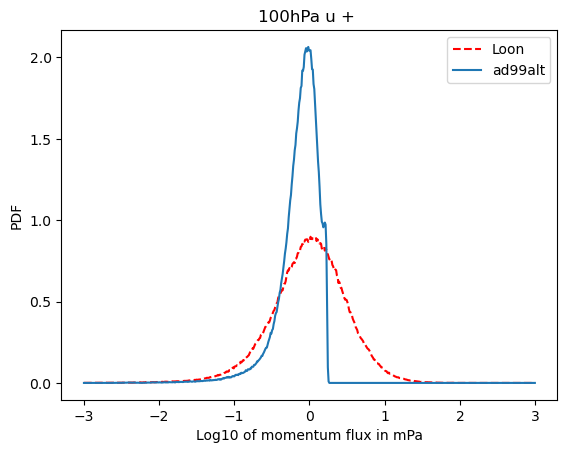

In [54]:
plot_log_histogram(uw_ptv_offline_alt,labels=['ad99alt'],title=f'{level}hPa u + ')


<Axes: title={'center': '100hPa u + '}, xlabel='Momentum flux (mPa)', ylabel='PDF'>

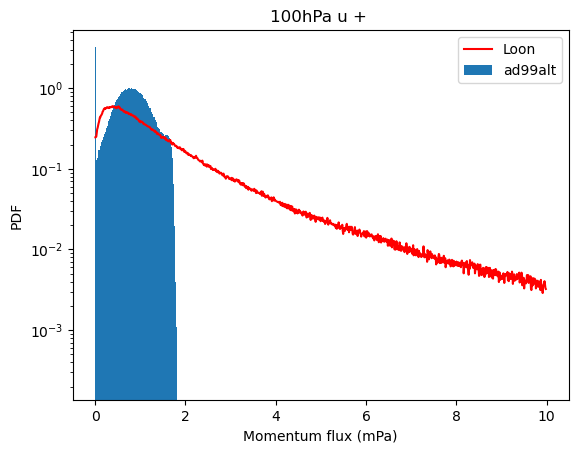

In [55]:
plot_log_y_histogram(uw_ptv_offline_alt,labels=['ad99alt'],title=f'{level}hPa u + ')


### Absolute Flux

In [99]:
level = 80
uw_abs_alt_lvl = flatten_flux(uw_abs_alt,level)



/var/folders/58/1mynp4bn1pg61mc1j6p3nnxc0000gp/T/ipykernel_69899/2979823329.py:11: RuntimeWarning: divide by zero encountered in log10
  hist, bin_edges = np.histogram(np.log10(d), bins=bins,density=True)


<Axes: title={'center': '80hPa abs'}, xlabel='Log10 of momentum flux in mPa', ylabel='PDF'>

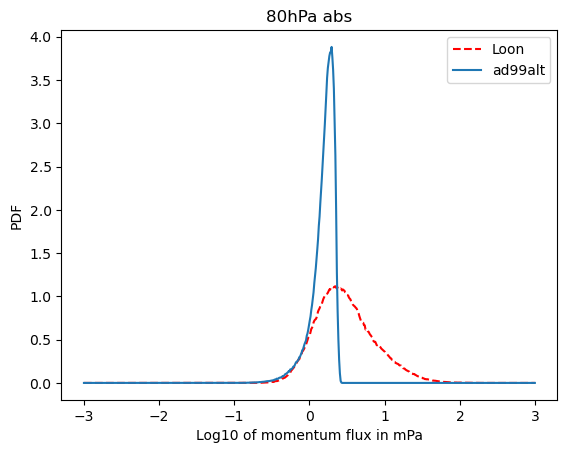

In [100]:
plot_log_histogram(uw_abs_alt_lvl,labels=['ad99alt'],title=f'{level}hPa abs',loon='u_flux_abs')


<Axes: title={'center': '80hPa abs'}, xlabel='Momentum flux (mPa)', ylabel='PDF'>

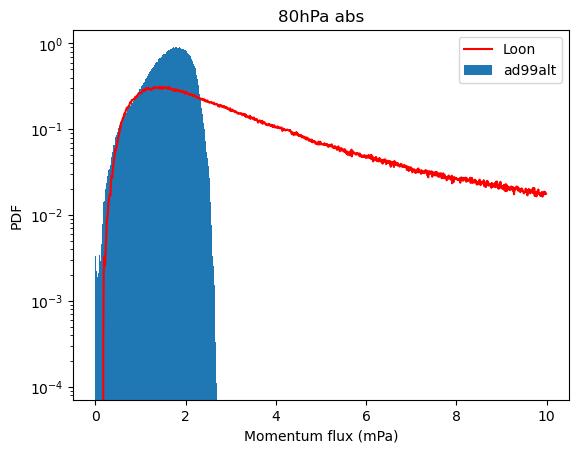

In [101]:
plot_log_y_histogram(uw_abs_alt_lvl,labels=['ad99alt'],title=f'{level}hPa abs',loon='u_flux_abs')

## Absolute Net Flux

In [84]:
level = 800
uw_ad99_bottom = uw_ptv_bottom + uw_ntv_bottom
uw_mima_bottom = uw_mima_ptv_bottom + uw_mima_ntv_bottom
uw_mima_top = uw_mima_ptv_top + uw_mima_ntv_top
uw_ad99_top = uw_ptv_top + uw_ntv_top
uw_ad99_alt = uw_ptv_alt + uw_ntv_alt
uw_mima_bottom = flatten_flux(uw_mima_bottom,level)
uw_mima_top = flatten_flux(uw_mima_top,level)
uw_ad99_bottom = flatten_flux(uw_ad99_bottom,level)
uw_ad99_top = flatten_flux(uw_ad99_top,level)
uw_ad99_alt = flatten_flux(uw_ad99_alt,level)   


In [85]:
vals,bins = np.histogram(np.log10(uw_ad99_bottom),bins=np.arange(-3,3,0.01),density=True)
bc = 0.5*(bins[1:] + bins[:-1])
bc[vals.argmax()]

np.float64(-0.18500000000006)

In [86]:
np.where((np.log10(uw_ad99_bottom.reshape(360,2504)) > 0.24) & (np.log10(uw_ad99_bottom.reshape(360,2504)) < 0.25) )

(array([  0,   0,   0, ..., 339, 339, 339], shape=(2570,)),
 array([2409, 2448, 2449, ..., 2492, 2493, 2494], shape=(2570,)))

/var/folders/58/1mynp4bn1pg61mc1j6p3nnxc0000gp/T/ipykernel_69899/2979823329.py:11: RuntimeWarning: divide by zero encountered in log10
  hist, bin_edges = np.histogram(np.log10(d), bins=bins,density=True)


<Axes: title={'center': '800hPa net (bottom)'}, xlabel='Log10 of momentum flux in mPa', ylabel='PDF'>

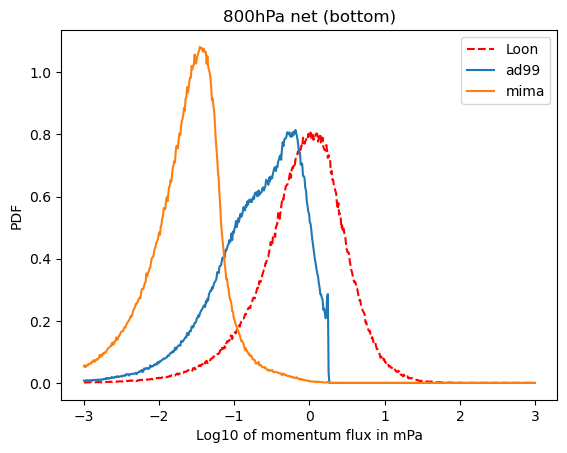

In [90]:
plot_log_histogram(uw_ad99_bottom,uw_mima_bottom,labels=['ad99','mima'],title=f'{level}hPa net (bottom)',loon='u_flux_net')

/var/folders/58/1mynp4bn1pg61mc1j6p3nnxc0000gp/T/ipykernel_69899/2979823329.py:11: RuntimeWarning: divide by zero encountered in log10
  hist, bin_edges = np.histogram(np.log10(d), bins=bins,density=True)


<Axes: title={'center': '800hPa net (top)'}, xlabel='Log10 of momentum flux in mPa', ylabel='PDF'>

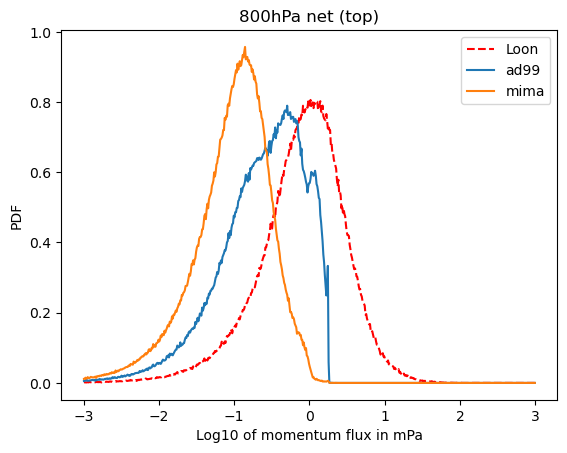

In [88]:
plot_log_histogram(uw_ad99_top,uw_mima_top,labels=['ad99','mima'],title=f'{level}hPa net (top)',loon='u_flux_net')

<Axes: title={'center': '80hPa net'}, xlabel='Log10 of momentum flux in mPa', ylabel='PDF'>

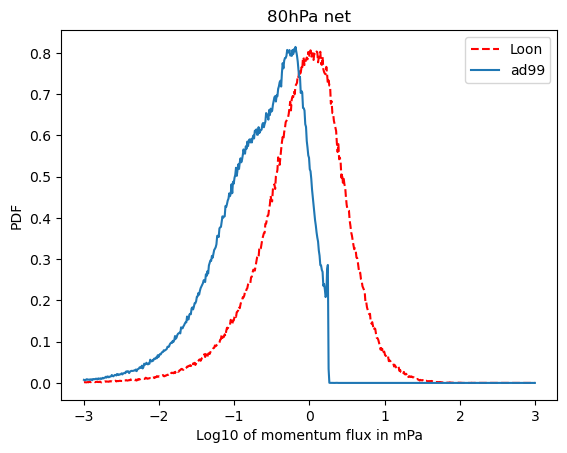

In [122]:
plot_log_histogram(uw_ad99_alt,labels=['ad99'],title=f'{level}hPa net',loon='u_flux_net')